In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch import nn
from torch.nn import functional
from PIL import Image
import os
from torchvision import datasets, transforms, models
from collections import defaultdict
import albumentations as A
import numpy as np
import cv2

### Finding different shapes and channels of images in the dataset

In [2]:
folder_path = r'D:\Suchit\Breast-Cancer-Detection\Dataset_BUSI_with_GT'
image_shapes, mask_shapes = set(), set()
channels = set()
images, masks = [], []
for folder in os.listdir(folder_path):
    for image in os.listdir(os.path.join(folder_path, folder)):
        with Image.open(os.path.join(folder_path, folder, image)) as img:
            if 'mask' in image:
                mask_shapes.add(img.size)
                masks.append(os.path.join(folder_path, folder, image))
            else:
                image_shapes.add(img.size)
                images.append(os.path.join(folder_path, folder, image))
            channels.add(img.mode)
print(
    f'image shape length - {len(image_shapes)} and mask shape length - {len(mask_shapes)}')
print(f'number of channels - {len(channels)}')
print(f'channels - {channels}')

image shape length - 639 and mask shape length - 639
number of channels - 3
channels - {'RGBA', 'RGB', '1'}


### Finding the average height and width of the images to resize them

In [3]:
folder_path = r'D:\Suchit\Breast-Cancer-Detection\Dataset_BUSI_with_GT'
height, width, num_samples = 0.0, 0.0, 0.0
for folder in os.listdir(folder_path):
    for image in os.listdir(os.path.join(folder_path, folder)):
        with Image.open(os.path.join(folder_path, folder, image)) as img:
            if 'mask' not in image:
                size = img.size
                height += size[1]
                width += size[0]
                num_samples += 1
height /= num_samples
width /= num_samples
print(f'average height = {height}')
print(f'average width = {width}')

average height = 501.4525641025641
average width = 615.6794871794872


Height and width is too large. Taking 256 * 256

### Finding the mean and standard deviation of the input images

In [4]:
def calculate_grayscale_stats(folder_path, resize_shape=(256, 256)):
    """Calculate mean and std for grayscale images"""
    print("Calculating grayscale statistics...")

    # Simple transform for grayscale statistics calculation
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(resize_shape),
        transforms.ToTensor()
    ])

    class GrayscaleImageData(Dataset):
        def __init__(self, images, transform):
            self.images = images
            self.transform = transform

        def __len__(self):
            return len(self.images)

        def __getitem__(self, index):
            img_path = self.images[index]
            image = Image.open(img_path)
            return self.transform(image)

    # Get image paths (exclude masks)
    images = []
    for folder in os.listdir(folder_path):
        for image in os.listdir(os.path.join(folder_path, folder)):
            if 'mask' not in image:
                images.append(os.path.join(folder_path, folder, image))

    print(f"Found {len(images)} images for statistics calculation")

    dataset = GrayscaleImageData(images, transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)

    mean, std, num_samples = 0.0, 0.0, 0.0

    for data in loader:
        batch_size = data.size(0)
        data = data.view(batch_size, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        num_samples += batch_size

    mean /= num_samples
    std /= num_samples

    return mean.item(), std.item()


# Step 2: Calculate grayscale statistics for your dataset
grayscale_mean, grayscale_std = calculate_grayscale_stats(folder_path)
print(f'Grayscale mean = {grayscale_mean:.4f}, std = {grayscale_std:.4f}')

Calculating grayscale statistics...
Found 780 images for statistics calculation
Grayscale mean = 0.3279, std = 0.1998


### Managing the dataset

In [5]:
from albumentations.pytorch import ToTensorV2


class Data(Dataset):
    def __init__(self, folder_path, transforms):
        super().__init__()
        self.images, self.masks, self.category = [], defaultdict(list), []
        classes = {'benign': 0, 'malignant': 1, 'normal': 2}
        self.transforms = transforms

        for folder in os.listdir(folder_path):
            for image in os.listdir(os.path.join(folder_path, folder)):
                img_path = os.path.join(folder_path, folder, image)
                if 'mask' in image:
                    self.masks[image[: image.index('_mask')]].append(img_path)
                else:
                    self.images.append(img_path)
                    self.category.append(classes[folder])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        key = os.path.basename(image_path)[
            : os.path.basename(image_path).index('.png')]
        mask_paths = self.masks[key]

        # Load image and masks as numpy arrays
        image = np.array(Image.open(image_path).convert('L'))
        masks = [np.array(Image.open(x).convert('L')) for x in mask_paths]

        # Combine masks
        mask = np.sum(np.stack(masks), axis=0)
        mask = np.clip(mask, 0, 1)  # ensure binary

        # Apply albumentations
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask, self.category[index]


transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[grayscale_mean], std=[grayscale_std]),
    ToTensorV2()
])

dataset = Data(folder_path, transform)

### Calculating positive weight to upweight the positive pixels in BCE loss

In [6]:
def estimate_pos_weight(dataset):
    loader = DataLoader(dataset= dataset, batch_size=16, shuffle= False)
    pos, neg = 0, 0
    with torch.no_grad():
        for _, mask, _ in loader:
            mask = mask.flatten()
            mask = (mask > 0)
            pos += mask.sum().item()
            neg += mask.numel() - mask.sum().item()
    if pos == 0:
        return torch.tensor(1.0)
    return torch.tensor(neg / pos)

# making counting transforms for counting the pos weights

count_transform = A.Compose([
    A.Resize(256, 256, interpolation= cv2.INTER_NEAREST, mask_interpolation= cv2.INTER_NEAREST),
    A.Normalize(mean = [grayscale_mean], std= [grayscale_std]),
    A.pytorch.ToTensorV2()
])
count_dataset = Data(folder_path= folder_path, transforms= count_transform)
pos_weight = estimate_pos_weight(count_dataset)
pos_weight = pos_weight.to('cuda')
print(f'Estimated positive weight = {pos_weight}')

Estimated positive weight = 11.776581764221191


### Model

In [7]:
def init_unet_kaiming(module):
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
        if module.weight is not None:
            nn.init.kaiming_normal_(module.weight, nonlinearity= 'relu')
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Linear):
        if module.weight is not None:
            nn.init.kaiming_normal_(module.weight, nonlinearity= 'relu')
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.BatchNorm2d):
        if getattr(module, 'weight', None) is not None:
            nn.init.ones_(module.weight)
        if getattr(module, 'bias', None) is not None:
            nn.init.zeros_(module.bias)

def zero_init_seg_head(head):
    if isinstance(head, nn.Conv2d):
        nn.init.zeros_(head.weight)
        if head.bias is not None:
            nn.init.zeros_(head.bias)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels,
                      kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)


class UNetWithClassifier(nn.Module):
    def __init__(self, in_channels=1, seg_out_channels=1, num_classes=3, p_drop=0.2):
        super().__init__()
        # Encoder
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)

        # Decoder (with concatenations)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = DoubleConv(512, 256)   # 512 up + 512 skip

        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = DoubleConv(256, 128)    # 256 up + 256 skip

        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = DoubleConv(128, 64)     # 64 up + 64 skip

        self.seg_head = nn.Conv2d(64, seg_out_channels, kernel_size=1)

        # Classification head on bottleneck features
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.cls_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256, bias=True),
            nn.Dropout(p_drop),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        self.apply(init_unet_kaiming)
        zero_init_seg_head(self.seg_head)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        d3 = self.down3(p2)
        p3 = self.pool3(d3)

        bn = self.bottleneck(p3)

        u3 = self.up3(bn)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.dec3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.dec2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.dec1(u1)

        seg_logits = self.seg_head(u1)
        cls_logits = self.cls_head(self.gap(bn))
        return seg_logits, cls_logits

### Loss function

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth = 1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, output_mask, targets):
        targets = targets.float()
        probs = torch.sigmoid(output_mask)
        # no. of batches
        B = output_mask.shape[0]
        probs_flatten = probs.view(B, -1)
        targs_flatten = targets.view(B, -1)
        intersection = (probs_flatten * targs_flatten).sum(dim = 1)
        p_sum = probs_flatten.sum(dim = 1)
        t_sum = targs_flatten.sum(dim = 1)
        # identifying empty target images
        empty = (t_sum == 0)
        # standard dice for non empty
        dice_non_empty = (2 * intersection + self.smooth) / (p_sum + t_sum + self.smooth)
        # defining dice for empty target images
        # if predictions also empty -> 1, else -> (smooth) / (psum + smooth)
        dice_empty = torch.where((p_sum == 0), torch.ones_like(p_sum), (self.smooth) / (p_sum + self.smooth))
        dice = torch.where(empty, dice_empty, dice_non_empty)
        return 1 - dice.mean()
    
class MultiTaskLoss(nn.Module):
    def __init__(self, bce_pos_weight):
        super().__init__()
        self.seg_weight = 1.0
        self.cls_weight = 0.5
        self.bce_weight = 0.5
        self.dice_weight = 0.5
        self.bce = nn.BCEWithLogitsLoss(pos_weight= bce_pos_weight)
        self.dice = DiceLoss()
        self.crossentropy = nn.CrossEntropyLoss()
    def forward(self, output_mask, target_mask, output_class_logits, class_logits):
        loss_bce = self.bce(output_mask, target_mask)
        loss_dice = self.dice(output_mask, target_mask)
        
        loss_mask = self.bce_weight * loss_bce + self.dice_weight * loss_dice

        loss_classification = self.crossentropy(output_class_logits  , class_logits.long())

        total = self.seg_weight * loss_mask + self.cls_weight * loss_classification

        return total



### Initializations

In [9]:
# model
model = UNetWithClassifier()
model = model.to('cuda')

# loss function
criterion = MultiTaskLoss(pos_weight)

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.001, weight_decay= 0.0001)

# train test split
n_total = len(dataset)
n_val = int(0.2 * n_total)
n_train = n_total - n_val
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_val], generator= torch.Generator().manual_seed(42))

# weighted random sampler
labels = np.array([dataset.category[i] for i in train_dataset.indices])
class_counts = np.bincount(labels, minlength= 3)
class_weights = class_counts.sum() / (len(class_counts) * class_counts.clip(min= 1))
sample_weights = [class_weights[x] for x in labels]

sampler = WeightedRandomSampler(weights= torch.tensor(sample_weights), num_samples= len(sample_weights), replacement= True)

# DataLoaders
train_loader = DataLoader(dataset= train_dataset, batch_size= 16, sampler= sampler, pin_memory= True)
test_loader = DataLoader(dataset= test_dataset, batch_size= 16, shuffle= False, pin_memory= True)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer= optimizer, mode= 'min', factor = 0.1, patience= 10, cooldown= 4)

### Training

In [10]:
from tqdm import trange

train_loss, test_loss = [], []

num_epochs = 500
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in trange(num_epochs, desc="Epochs"):
    model.train()
    running_loss = 0.0
    for images, masks, labels in train_loader:
        images = images.to('cuda')
        masks = masks.to('cuda').view(-1, 1, 256, 256).float()
        labels = labels.to('cuda')

        optimizer.zero_grad()
        mask_pred, output_class_logits = model(images)
        loss = criterion(mask_pred, masks, output_class_logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, masks, labels in test_loader:
            images = images.to('cuda')
            masks = masks.to('cuda').view(-1, 1, 256, 256).float()
            labels = labels.to('cuda')
            mask_pred, output_class_logits = model(images)
            loss = criterion(mask_pred, masks, output_class_logits, labels)
            val_loss += loss.item()
            output_classes = output_class_logits.argmax(dim= 1)
            correct += (output_classes == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(test_loader)

    scheduler.step(val_loss)

    val_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_loss:.6f} | Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.2f}%")
    
    train_loss.append(avg_loss)
    test_loss.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epochs:   0%|          | 1/500 [00:33<4:39:05, 33.56s/it]

Epoch [1/500] Train Loss: 1.531304 | Val Loss: 2.910047 | Val Acc: 45.51%


Epochs:   0%|          | 2/500 [01:05<4:29:23, 32.46s/it]

Epoch [2/500] Train Loss: 1.400446 | Val Loss: 2.183480 | Val Acc: 52.56%


Epochs:   1%|          | 3/500 [01:36<4:26:00, 32.11s/it]

Epoch [3/500] Train Loss: 1.354849 | Val Loss: 1.470143 | Val Acc: 46.79%


Epochs:   1%|          | 4/500 [02:07<4:21:11, 31.60s/it]

Epoch [4/500] Train Loss: 1.273285 | Val Loss: 2.330193 | Val Acc: 61.54%


Epochs:   1%|          | 5/500 [02:38<4:18:16, 31.31s/it]

Epoch [5/500] Train Loss: 1.224789 | Val Loss: 1.186123 | Val Acc: 66.03%


Epochs:   1%|          | 6/500 [03:09<4:15:42, 31.06s/it]

Epoch [6/500] Train Loss: 1.199992 | Val Loss: 1.780670 | Val Acc: 59.62%


Epochs:   1%|▏         | 7/500 [03:39<4:14:06, 30.93s/it]

Epoch [7/500] Train Loss: 1.115822 | Val Loss: 1.253153 | Val Acc: 66.03%


Epochs:   2%|▏         | 8/500 [04:10<4:13:59, 30.98s/it]

Epoch [8/500] Train Loss: 1.021231 | Val Loss: 1.454805 | Val Acc: 64.10%


Epochs:   2%|▏         | 9/500 [04:42<4:13:56, 31.03s/it]

Epoch [9/500] Train Loss: 1.045344 | Val Loss: 1.362306 | Val Acc: 61.54%


Epochs:   2%|▏         | 10/500 [05:13<4:14:04, 31.11s/it]

Epoch [10/500] Train Loss: 1.112939 | Val Loss: 1.364918 | Val Acc: 49.36%


Epochs:   2%|▏         | 11/500 [05:43<4:11:52, 30.90s/it]

Epoch [11/500] Train Loss: 1.027536 | Val Loss: 1.397114 | Val Acc: 48.72%


Epochs:   2%|▏         | 12/500 [06:14<4:10:06, 30.75s/it]

Epoch [12/500] Train Loss: 0.996106 | Val Loss: 1.275468 | Val Acc: 66.03%


Epochs:   3%|▎         | 13/500 [06:44<4:08:40, 30.64s/it]

Epoch [13/500] Train Loss: 1.031751 | Val Loss: 1.109099 | Val Acc: 64.10%


Epochs:   3%|▎         | 14/500 [07:14<4:07:26, 30.55s/it]

Epoch [14/500] Train Loss: 0.979325 | Val Loss: 1.170295 | Val Acc: 62.82%


Epochs:   3%|▎         | 15/500 [07:45<4:06:33, 30.50s/it]

Epoch [15/500] Train Loss: 0.989768 | Val Loss: 1.325470 | Val Acc: 60.26%


Epochs:   3%|▎         | 16/500 [08:15<4:05:53, 30.48s/it]

Epoch [16/500] Train Loss: 0.956516 | Val Loss: 1.593944 | Val Acc: 50.00%


Epochs:   3%|▎         | 17/500 [08:46<4:05:04, 30.44s/it]

Epoch [17/500] Train Loss: 0.932720 | Val Loss: 1.001357 | Val Acc: 74.36%


Epochs:   4%|▎         | 18/500 [09:16<4:04:47, 30.47s/it]

Epoch [18/500] Train Loss: 0.916718 | Val Loss: 1.052582 | Val Acc: 67.95%


Epochs:   4%|▍         | 19/500 [09:46<4:03:56, 30.43s/it]

Epoch [19/500] Train Loss: 0.942648 | Val Loss: 1.046294 | Val Acc: 75.64%


Epochs:   4%|▍         | 20/500 [10:17<4:03:32, 30.44s/it]

Epoch [20/500] Train Loss: 0.902015 | Val Loss: 1.103165 | Val Acc: 72.44%


Epochs:   4%|▍         | 21/500 [10:47<4:03:02, 30.44s/it]

Epoch [21/500] Train Loss: 0.954789 | Val Loss: 0.995212 | Val Acc: 72.44%


Epochs:   4%|▍         | 22/500 [11:18<4:02:13, 30.41s/it]

Epoch [22/500] Train Loss: 0.928797 | Val Loss: 1.328694 | Val Acc: 57.69%


Epochs:   5%|▍         | 23/500 [11:48<4:01:31, 30.38s/it]

Epoch [23/500] Train Loss: 0.889279 | Val Loss: 1.276215 | Val Acc: 64.10%


Epochs:   5%|▍         | 24/500 [12:18<4:00:55, 30.37s/it]

Epoch [24/500] Train Loss: 0.896228 | Val Loss: 0.991025 | Val Acc: 77.56%


Epochs:   5%|▌         | 25/500 [12:49<4:00:29, 30.38s/it]

Epoch [25/500] Train Loss: 0.874152 | Val Loss: 1.149483 | Val Acc: 68.59%


Epochs:   5%|▌         | 26/500 [13:19<3:59:53, 30.37s/it]

Epoch [26/500] Train Loss: 0.878496 | Val Loss: 0.989468 | Val Acc: 70.51%


Epochs:   5%|▌         | 27/500 [13:50<3:59:42, 30.41s/it]

Epoch [27/500] Train Loss: 0.838904 | Val Loss: 1.099254 | Val Acc: 75.64%


Epochs:   6%|▌         | 28/500 [14:20<3:59:18, 30.42s/it]

Epoch [28/500] Train Loss: 0.830514 | Val Loss: 0.987141 | Val Acc: 74.36%


Epochs:   6%|▌         | 29/500 [14:50<3:58:34, 30.39s/it]

Epoch [29/500] Train Loss: 0.856781 | Val Loss: 1.172898 | Val Acc: 50.00%


Epochs:   6%|▌         | 30/500 [15:21<3:58:35, 30.46s/it]

Epoch [30/500] Train Loss: 0.857582 | Val Loss: 1.030593 | Val Acc: 66.03%


Epochs:   6%|▌         | 31/500 [15:51<3:57:27, 30.38s/it]

Epoch [31/500] Train Loss: 0.804711 | Val Loss: 1.210733 | Val Acc: 67.31%


Epochs:   6%|▋         | 32/500 [16:21<3:56:37, 30.34s/it]

Epoch [32/500] Train Loss: 0.840503 | Val Loss: 1.094167 | Val Acc: 69.23%


Epochs:   7%|▋         | 33/500 [16:52<3:56:03, 30.33s/it]

Epoch [33/500] Train Loss: 0.813990 | Val Loss: 0.993214 | Val Acc: 72.44%


Epochs:   7%|▋         | 34/500 [17:22<3:55:21, 30.30s/it]

Epoch [34/500] Train Loss: 0.849753 | Val Loss: 1.073260 | Val Acc: 71.15%


Epochs:   7%|▋         | 35/500 [17:52<3:55:08, 30.34s/it]

Epoch [35/500] Train Loss: 0.832041 | Val Loss: 1.121980 | Val Acc: 75.00%


Epochs:   7%|▋         | 36/500 [18:23<3:54:29, 30.32s/it]

Epoch [36/500] Train Loss: 0.809247 | Val Loss: 0.994216 | Val Acc: 73.72%


Epochs:   7%|▋         | 37/500 [18:53<3:54:09, 30.34s/it]

Epoch [37/500] Train Loss: 0.787550 | Val Loss: 0.978072 | Val Acc: 79.49%


Epochs:   8%|▊         | 38/500 [19:23<3:53:52, 30.37s/it]

Epoch [38/500] Train Loss: 0.780419 | Val Loss: 1.152328 | Val Acc: 71.15%


Epochs:   8%|▊         | 39/500 [19:54<3:52:48, 30.30s/it]

Epoch [39/500] Train Loss: 0.747355 | Val Loss: 1.100619 | Val Acc: 71.79%


Epochs:   8%|▊         | 40/500 [20:24<3:52:20, 30.31s/it]

Epoch [40/500] Train Loss: 0.746710 | Val Loss: 0.911655 | Val Acc: 80.13%


Epochs:   8%|▊         | 41/500 [20:54<3:51:35, 30.27s/it]

Epoch [41/500] Train Loss: 0.763886 | Val Loss: 1.029100 | Val Acc: 75.00%


Epochs:   8%|▊         | 42/500 [21:24<3:51:12, 30.29s/it]

Epoch [42/500] Train Loss: 0.815022 | Val Loss: 1.016286 | Val Acc: 78.21%


Epochs:   9%|▊         | 43/500 [21:55<3:50:45, 30.30s/it]

Epoch [43/500] Train Loss: 0.709783 | Val Loss: 0.965584 | Val Acc: 78.21%


Epochs:   9%|▉         | 44/500 [22:25<3:50:48, 30.37s/it]

Epoch [44/500] Train Loss: 0.773732 | Val Loss: 1.019042 | Val Acc: 76.92%


Epochs:   9%|▉         | 45/500 [22:55<3:49:47, 30.30s/it]

Epoch [45/500] Train Loss: 0.781687 | Val Loss: 1.228967 | Val Acc: 61.54%


Epochs:   9%|▉         | 46/500 [23:26<3:49:15, 30.30s/it]

Epoch [46/500] Train Loss: 0.713408 | Val Loss: 1.035244 | Val Acc: 75.64%


Epochs:   9%|▉         | 47/500 [23:56<3:48:56, 30.32s/it]

Epoch [47/500] Train Loss: 0.707803 | Val Loss: 1.103348 | Val Acc: 61.54%


Epochs:  10%|▉         | 48/500 [24:27<3:48:37, 30.35s/it]

Epoch [48/500] Train Loss: 0.669483 | Val Loss: 1.449539 | Val Acc: 71.79%


Epochs:  10%|▉         | 49/500 [24:57<3:48:13, 30.36s/it]

Epoch [49/500] Train Loss: 0.735113 | Val Loss: 1.194201 | Val Acc: 68.59%


Epochs:  10%|█         | 50/500 [25:27<3:47:17, 30.30s/it]

Epoch [50/500] Train Loss: 0.727082 | Val Loss: 1.295967 | Val Acc: 60.26%


Epochs:  10%|█         | 51/500 [25:57<3:46:48, 30.31s/it]

Epoch [51/500] Train Loss: 0.707763 | Val Loss: 0.900178 | Val Acc: 82.69%


Epochs:  10%|█         | 52/500 [26:28<3:45:58, 30.26s/it]

Epoch [52/500] Train Loss: 0.678440 | Val Loss: 0.995156 | Val Acc: 82.05%


Epochs:  11%|█         | 53/500 [26:58<3:45:22, 30.25s/it]

Epoch [53/500] Train Loss: 0.657159 | Val Loss: 0.986037 | Val Acc: 75.64%


Epochs:  11%|█         | 54/500 [27:28<3:44:39, 30.22s/it]

Epoch [54/500] Train Loss: 0.678882 | Val Loss: 1.316020 | Val Acc: 68.59%


Epochs:  11%|█         | 55/500 [27:58<3:43:57, 30.20s/it]

Epoch [55/500] Train Loss: 0.623535 | Val Loss: 0.926919 | Val Acc: 78.85%


Epochs:  11%|█         | 56/500 [28:29<3:44:04, 30.28s/it]

Epoch [56/500] Train Loss: 0.652579 | Val Loss: 1.221823 | Val Acc: 74.36%


Epochs:  11%|█▏        | 57/500 [28:59<3:43:37, 30.29s/it]

Epoch [57/500] Train Loss: 0.630851 | Val Loss: 0.953142 | Val Acc: 81.41%


Epochs:  12%|█▏        | 58/500 [29:29<3:43:11, 30.30s/it]

Epoch [58/500] Train Loss: 0.608364 | Val Loss: 0.912460 | Val Acc: 84.62%


Epochs:  12%|█▏        | 59/500 [29:59<3:42:39, 30.29s/it]

Epoch [59/500] Train Loss: 0.582856 | Val Loss: 1.024650 | Val Acc: 82.69%


Epochs:  12%|█▏        | 60/500 [30:29<3:41:34, 30.21s/it]

Epoch [60/500] Train Loss: 0.644178 | Val Loss: 1.080957 | Val Acc: 76.92%


Epochs:  12%|█▏        | 61/500 [31:00<3:41:13, 30.24s/it]

Epoch [61/500] Train Loss: 0.608004 | Val Loss: 1.093925 | Val Acc: 80.77%


Epochs:  12%|█▏        | 62/500 [31:30<3:40:59, 30.27s/it]

Epoch [62/500] Train Loss: 0.608626 | Val Loss: 1.085715 | Val Acc: 79.49%


Epochs:  13%|█▎        | 63/500 [32:01<3:40:53, 30.33s/it]

Epoch [63/500] Train Loss: 0.558297 | Val Loss: 0.888327 | Val Acc: 80.77%


Epochs:  13%|█▎        | 64/500 [32:31<3:40:26, 30.34s/it]

Epoch [64/500] Train Loss: 0.558097 | Val Loss: 0.897967 | Val Acc: 80.13%


Epochs:  13%|█▎        | 65/500 [33:01<3:39:48, 30.32s/it]

Epoch [65/500] Train Loss: 0.528984 | Val Loss: 0.896322 | Val Acc: 84.62%


Epochs:  13%|█▎        | 66/500 [33:31<3:38:58, 30.27s/it]

Epoch [66/500] Train Loss: 0.507513 | Val Loss: 0.887686 | Val Acc: 85.26%


Epochs:  13%|█▎        | 67/500 [34:02<3:38:54, 30.33s/it]

Epoch [67/500] Train Loss: 0.514704 | Val Loss: 0.912582 | Val Acc: 83.33%


Epochs:  14%|█▎        | 68/500 [34:32<3:38:56, 30.41s/it]

Epoch [68/500] Train Loss: 0.509050 | Val Loss: 0.884388 | Val Acc: 85.26%


Epochs:  14%|█▍        | 69/500 [35:03<3:37:57, 30.34s/it]

Epoch [69/500] Train Loss: 0.490780 | Val Loss: 0.914655 | Val Acc: 83.33%


Epochs:  14%|█▍        | 70/500 [35:34<3:38:58, 30.56s/it]

Epoch [70/500] Train Loss: 0.494660 | Val Loss: 0.919146 | Val Acc: 83.33%


Epochs:  14%|█▍        | 71/500 [36:05<3:40:39, 30.86s/it]

Epoch [71/500] Train Loss: 0.497400 | Val Loss: 0.939739 | Val Acc: 85.26%


Epochs:  14%|█▍        | 72/500 [36:37<3:41:19, 31.03s/it]

Epoch [72/500] Train Loss: 0.491070 | Val Loss: 0.937273 | Val Acc: 84.62%


Epochs:  15%|█▍        | 73/500 [37:08<3:41:58, 31.19s/it]

Epoch [73/500] Train Loss: 0.484318 | Val Loss: 0.935821 | Val Acc: 83.33%


Epochs:  15%|█▍        | 74/500 [37:40<3:42:29, 31.34s/it]

Epoch [74/500] Train Loss: 0.485765 | Val Loss: 0.910548 | Val Acc: 84.62%


Epochs:  15%|█▌        | 75/500 [38:11<3:42:07, 31.36s/it]

Epoch [75/500] Train Loss: 0.489113 | Val Loss: 0.902865 | Val Acc: 85.90%


Epochs:  15%|█▌        | 76/500 [38:43<3:41:32, 31.35s/it]

Epoch [76/500] Train Loss: 0.480044 | Val Loss: 0.903798 | Val Acc: 83.97%


Epochs:  15%|█▌        | 77/500 [39:14<3:41:31, 31.42s/it]

Epoch [77/500] Train Loss: 0.470673 | Val Loss: 0.929325 | Val Acc: 85.26%


Epochs:  16%|█▌        | 78/500 [39:46<3:41:24, 31.48s/it]

Epoch [78/500] Train Loss: 0.458235 | Val Loss: 0.908876 | Val Acc: 84.62%


Epochs:  16%|█▌        | 79/500 [40:18<3:41:24, 31.55s/it]

Epoch [79/500] Train Loss: 0.483933 | Val Loss: 0.942236 | Val Acc: 83.97%


Epochs:  16%|█▌        | 80/500 [40:49<3:40:51, 31.55s/it]

Epoch [80/500] Train Loss: 0.476154 | Val Loss: 0.947859 | Val Acc: 83.97%


Epochs:  16%|█▌        | 81/500 [41:21<3:40:34, 31.59s/it]

Epoch [81/500] Train Loss: 0.466638 | Val Loss: 0.901240 | Val Acc: 84.62%


Epochs:  16%|█▋        | 82/500 [41:52<3:39:50, 31.56s/it]

Epoch [82/500] Train Loss: 0.468238 | Val Loss: 0.916066 | Val Acc: 85.26%


Epochs:  17%|█▋        | 83/500 [42:24<3:39:04, 31.52s/it]

Epoch [83/500] Train Loss: 0.459763 | Val Loss: 0.936199 | Val Acc: 84.62%


Epochs:  17%|█▋        | 84/500 [42:55<3:38:15, 31.48s/it]

Epoch [84/500] Train Loss: 0.458182 | Val Loss: 0.901224 | Val Acc: 84.62%


Epochs:  17%|█▋        | 85/500 [43:27<3:37:39, 31.47s/it]

Epoch [85/500] Train Loss: 0.456044 | Val Loss: 0.937945 | Val Acc: 86.54%


Epochs:  17%|█▋        | 86/500 [43:58<3:37:01, 31.45s/it]

Epoch [86/500] Train Loss: 0.492726 | Val Loss: 0.924663 | Val Acc: 85.90%


Epochs:  17%|█▋        | 87/500 [44:29<3:36:21, 31.43s/it]

Epoch [87/500] Train Loss: 0.464855 | Val Loss: 0.952761 | Val Acc: 85.26%


Epochs:  17%|█▋        | 87/500 [45:01<3:33:43, 31.05s/it]

Epoch [88/500] Train Loss: 0.449035 | Val Loss: 0.941186 | Val Acc: 85.90%
Early stopping at epoch 88


### Saving loss lists

In [11]:
import pandas as pd
train_pd = pd.DataFrame(train_loss)
train_pd.to_csv('train_loss.csv', index= False, header= False)
test_pd = pd.DataFrame(test_loss)
test_pd.to_csv('test_loss.csv', index= False, header= False)

In [12]:
from torchmetrics.classification import MulticlassPrecision

model.eval()
preds, targets = [], []

with torch.no_grad():
    for images, masks, labels in test_loader:
        images = images.to('cuda')
        masks = masks.to('cuda').view(-1, 1, 256, 256).float()
        labels = labels.to('cuda')

        seg_logits, cls_logits = model(images)
        pred_cls = cls_logits.argmax(dim=1)  # (B,)

        preds.append(pred_cls.cpu())
        targets.append(labels.cpu())

preds = torch.cat(preds)      # shape (N,)
targets = torch.cat(targets)  # shape (N,)

metric = MulticlassPrecision(num_classes=3, average="macro")
precision_macro = metric(preds, targets).item()
print("Macro Precision:", precision_macro)

Macro Precision: 0.8778735399246216


In [13]:
from torchmetrics.classification import MulticlassPrecision

prec_macro = MulticlassPrecision(num_classes=3, average="macro")(preds, targets).item()
prec_micro = MulticlassPrecision(num_classes=3, average="micro")(preds, targets).item()
prec_weighted = MulticlassPrecision(num_classes=3, average="weighted")(preds, targets).item()
print(f"macro={prec_macro:.4f}  micro={prec_micro:.4f}  weighted={prec_weighted:.4f}")


macro=0.8779  micro=0.8590  weighted=0.8631


In [14]:
statedict = torch.load('model.pt')
model = UNetWithClassifier()
model = model.to('cuda')
model.load_state_dict(statedict)
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
)
from tabulate import tabulate

def evaluate_metrics(model, dataloader, device="cuda", num_classes=3):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for images, masks, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            _, cls_logits = model(images)
            pred_cls = cls_logits.argmax(dim=1)

            preds.append(pred_cls.cpu())
            targets.append(labels.cpu())

    preds = torch.cat(preds)
    targets = torch.cat(targets)

    # Macro / Micro / Weighted
    metrics = {
        "Accuracy": MulticlassAccuracy(num_classes=num_classes, average="micro")(preds, targets).item(),
        "Precision (macro)": MulticlassPrecision(num_classes=num_classes, average="macro")(preds, targets).item(),
        "Recall (macro)": MulticlassRecall(num_classes=num_classes, average="macro")(preds, targets).item(),
        "F1 (macro)": MulticlassF1Score(num_classes=num_classes, average="macro")(preds, targets).item(),
    }

    # Per-class metrics
    per_class_prec = MulticlassPrecision(num_classes=num_classes, average=None)(preds, targets)
    per_class_rec  = MulticlassRecall(num_classes=num_classes, average=None)(preds, targets)
    per_class_f1   = MulticlassF1Score(num_classes=num_classes, average=None)(preds, targets)

    # Print summary table
    summary_table = [[k, f"{v:.4f}"] for k, v in metrics.items()]
    print(tabulate(summary_table, headers=["Metric", "Score"], tablefmt="fancy_grid"))

    # Print per-class table
    class_table = []
    for i in range(num_classes):
        class_table.append([i, f"{per_class_prec[i]:.4f}", f"{per_class_rec[i]:.4f}", f"{per_class_f1[i]:.4f}"])
    print(tabulate(class_table, headers=["Class", "Precision", "Recall", "F1"], tablefmt="fancy_grid"))
evaluate_metrics(model, test_loader)

╒═══════════════════╤═════════╕
│ Metric            │   Score │
╞═══════════════════╪═════════╡
│ Accuracy          │  0.8397 │
├───────────────────┼─────────┤
│ Precision (macro) │  0.8607 │
├───────────────────┼─────────┤
│ Recall (macro)    │  0.8175 │
├───────────────────┼─────────┤
│ F1 (macro)        │  0.8348 │
╘═══════════════════╧═════════╛
╒═════════╤═════════════╤══════════╤════════╕
│   Class │   Precision │   Recall │     F1 │
╞═════════╪═════════════╪══════════╪════════╡
│       0 │      0.809  │   0.9231 │ 0.8623 │
├─────────┼─────────────┼──────────┼────────┤
│       1 │      0.8421 │   0.7111 │ 0.7711 │
├─────────┼─────────────┼──────────┼────────┤
│       2 │      0.931  │   0.8182 │ 0.871  │
╘═════════╧═════════════╧══════════╧════════╛


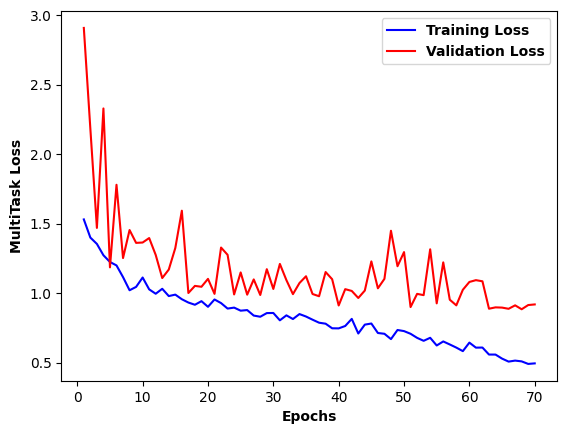

In [15]:
from matplotlib import pyplot as plt
import pandas as pd

train_loss = pd.read_csv('train_loss.csv', header= None).squeeze().tolist()
test_loss = pd.read_csv('test_loss.csv', header = None).squeeze().tolist()

plt.plot(range(1, 71), train_loss[: 70], color = 'blue', label = 'Training Loss')
plt.plot(range(1, 71), test_loss[: 70], color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs', fontweight = 'bold')
plt.ylabel('MultiTask Loss', fontweight = 'bold')
plt.legend(prop={'weight':'bold'})
plt.show()